# 1. Introduction

This report is aimed to analyze the road safety data in UK (https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data), these files provide detailed road safety data about the circumstances of personal injury road accidents, the types of vehicles involved, and the consequential casualties. The statistics relate only to personal injury accidents on public roads that are reported to the police and subsequently recorded, using the STATS19 accident reporting form. We use the files span from 2010 to 2019.

The purpose of the analysis including (1) summarize the main structure and characteristics of data with visual aids, and obtain interesting facts that are worth highlighting (2) Identity the relationship between variables and the casualties as well as the ratio of fatal casualties (3) provide some insight of how to predict at which condition the accident happen most, and which accident would be fatal.

# 2. File and data preprocessing


There are three different types of files in the dataset. The first type is the Accident Circumstances, which contain the records of the accident with its information such as the date, the environment of the accident. The second type is Casualty, which contains the records of the accident with the information about the victim such as the age, sex of transportation method. Finally, the Vehicle contains the records of the accident with the information about the driver and vehicle that cause the accident. 

I merge the same file across different years, and rename some variable aliased by in different year (e.g., “Act_Index” and “Accident_Index”). Here I found some missing value, largely due to the record format is a little different in a different year (e.g., “Casualty_IMD_Decile” column appear in some years but not in others). Instead of removing the entire row which contains a missing value, I choose to leave them and remove them when the analysis is related to these columns.

In [1]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from utils import *

In [2]:
def read_all_Accidents(start, end):
    dfs = []
    for y in range(start, end+1):
        df = pd.read_csv("data/Accidents_{}.csv".format(y))
        if 'Acc_Index' in df.columns:
            df = df.rename(columns={'Acc_Index':'Accident_Index'})
        dfs.append(df)
    return pd.concat(dfs)

def read_all_Casualties(start, end):
    dfs = []
    for y in range(start, end+1):
        df = pd.read_csv("data/Casualties_{}.csv".format(y))
        if 'Acc_Index' in df.columns:
            df = df.rename(columns={'Acc_Index':'Accident_Index'})
        if 'Casualty_Severity' in df.columns:
            df = df.rename(columns={"Casualty_Severity":"Accident_Severity"})
        dfs.append(df)
    return pd.concat(dfs)

def read_all_Vehicles(start, end):
    dfs = []
    for y in range(start, end+1):
        df_acc = pd.read_csv("data/Accidents_{}.csv".format(y))
        df_veh = pd.read_csv("data/Vehicles_{}.csv".format(y))
        if 'Acc_Index' in df_veh.columns:
            df_veh['Accident_Index'] = df_veh['Acc_Index']
        if 'Acc_Index' in df_acc.columns:
            df_acc['Accident_Index'] = df_acc['Acc_Index']
        df = pd.merge(df_acc[['Accident_Index', 'Accident_Severity']], df_veh)
        dfs.append(df)
    return pd.concat(dfs)

In [3]:
def remove_missing_value(df, cols):
    df_out = df[cols]
    n_missing_value = 0
    total = len(df_out)
    
    # Remove NaN
    n_missing_value += df_out.isnull().sum().sum()
    df_out = df_out.dropna()
    
    # Remove -1
    for col in cols:
        n_missing_value += len(df_out[df_out[col]==-1])
        df_out = df_out[df_out[col]!=-1]
        
    print("Number of missing value: {} ({:.2f}%)".format(n_missing_value, n_missing_value/total*100))
    return df_out

In [4]:
start_year = 2010
end_year = 2019

In [5]:
df_Accidents = read_all_Accidents(start_year, end_year)
df_Accidents.head(5)

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,201001BS70003,527580.0,177730.0,-0.164002,51.484087,1,3,2,1,11/01/2010,...,0,0,1,8,2,0,0,1,1,E01002900
1,201001BS70004,525340.0,180470.0,-0.195273,51.509212,1,3,1,1,11/01/2010,...,0,5,4,2,2,0,0,1,1,E01002884
2,201001BS70006,524800.0,180300.0,-0.203110,51.507804,1,3,2,1,12/01/2010,...,0,5,1,1,1,0,0,1,1,E01002871
3,201001BS70007,525080.0,180920.0,-0.198858,51.513314,1,3,2,1,02/01/2010,...,0,0,4,1,1,0,0,1,1,E01002886
4,201001BS70008,526760.0,177740.0,-0.175802,51.484361,1,3,2,1,04/01/2010,...,0,0,4,1,2,0,0,1,1,E01002845


In [6]:
df_Casualties = read_all_Casualties(start_year, end_year)
df_Casualties.head(5)

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_Band_of_Casualty,Accident_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Age_of_Casualty,Casualty_IMD_Decile
0,201001BS70003,2,1,1,1,6,3,0,0,0,0,-1,1,1,NaN,NaN
1,201001BS70004,1,1,3,1,8,3,4,3,0,0,-1,0,1,NaN,NaN
2,201001BS70006,2,1,1,1,6,3,0,0,0,0,-1,1,1,NaN,NaN
3,201001BS70007,1,1,2,1,-1,3,0,0,1,0,-1,9,1,NaN,NaN
4,201001BS70008,2,1,2,1,6,3,0,0,0,0,-1,5,1,NaN,NaN


In [7]:
df_Vehicles = read_all_Vehicles(start_year, end_year)
df_Vehicles.head(5)

,Accident_Index,Accident_Severity,Acc_Index,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,...,Sex_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Was_Vehicle_Left_Hand_Drive?,Age_of_Driver,Vehicle_IMD_Decile
0,201001BS70003,3,201001BS70003,1,19,0,9,0,8,0,...,2,7,1360,1,1,1,1,NaN,NaN,NaN
1,201001BS70003,3,201001BS70003,2,1,0,7,0,8,0,...,1,6,-1,-1,-1,8,1,NaN,NaN,NaN
2,201001BS70004,3,201001BS70004,1,9,0,18,0,8,0,...,1,8,1870,2,3,5,1,NaN,NaN,NaN
3,201001BS70006,3,201001BS70006,1,20,0,7,0,8,0,...,1,7,3920,2,8,2,1,NaN,NaN,NaN
4,201001BS70006,3,201001BS70006,2,1,0,15,0,8,0,...,1,6,-1,-1,-1,6,1,NaN,NaN,NaN


# 3. EDA 

## 3.1 Accident Circumstances

In [8]:
df_Accidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1383271 entries, 0 to 117535
Data columns (total 32 columns):
 #   Column                                       Non-Null Count    Dtype  
---  ------                                       --------------    -----  
 0   Accident_Index                               1383271 non-null  object 
 1   Location_Easting_OSGR                        1383135 non-null  float64
 2   Location_Northing_OSGR                       1383135 non-null  float64
 3   Longitude                                    1383125 non-null  float64
 4   Latitude                                     1383125 non-null  float64
 5   Police_Force                                 1383271 non-null  int64  
 6   Accident_Severity                            1383271 non-null  int64  
 7   Number_of_Vehicles                           1383271 non-null  int64  
 8   Number_of_Casualties                         1383271 non-null  int64  
 9   Date                                         13

In [9]:
df = remove_missing_value(df_Accidents, ['Accident_Index','Accident_Severity', 'Date', 'Day_of_Week', 'Time'])

Number of missing value: 132 (0.01%)


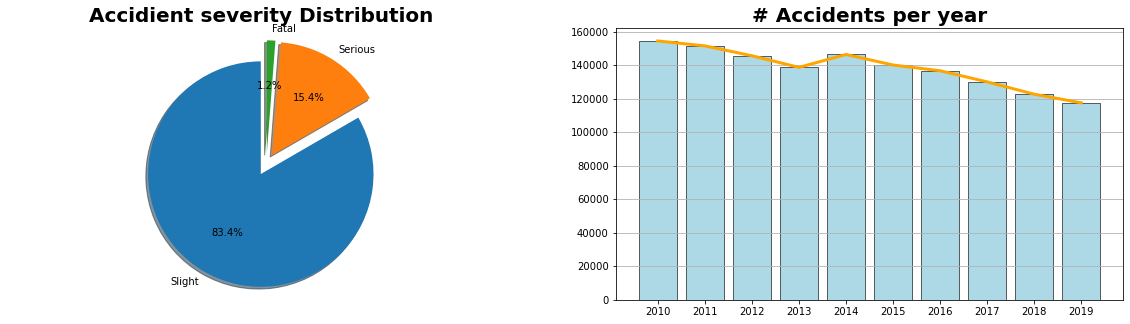

In [10]:
fig, axs = plt.subplots(1,2, figsize=(20,5))

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
ax = axs[0]
ax.set_title('Accidient severity Distribution', fontsize=20, fontweight='bold')
labels = [code2label('Casualty Severity', s) for s in range(3, 0, -1)]
sizes = [(df['Accident_Severity']==s).sum() for s in range(3, 0, -1)]
explode = (0.1, 0.1, 0.1) 
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Plot number of accidient per year
ax = axs[1]
plt.sca(ax)
plt.gca().yaxis.grid(True)
df['Year'] = pd.to_numeric(df['Date'].str[-4:]).astype('int')
year_cnts = df['Year'].value_counts().sort_index(ascending=True)
ax.set_xticks([y for y in range(start_year, end_year+1)])
ax.set_title('# Accidents per year', fontsize=20, fontweight='bold')
ax.bar(year_cnts.index, year_cnts.values, color='lightblue', edgecolor='black', linewidth=0.6)
ax.plot(year_cnts, color='orange',linewidth=3, linestyle='-')
plt.show()

First, we look at the trend of the number of accidents over the last few years, and we can find that the number of accidents has continued to decrease for the last 6 years (146k in 2014 down to 117k in 2019). In addition, the accident was a mostly slight accident (83.4%). 

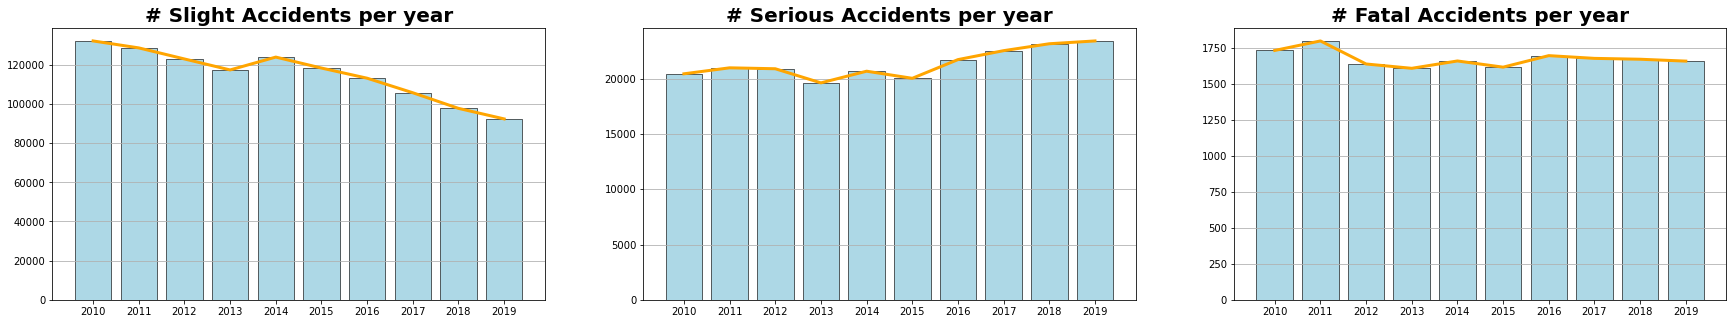

In [11]:
# Plot number of accidient of different Severity per year
fig, axs = plt.subplots(1,3, figsize=(30,5))
for i, s in enumerate(range(3, 1-1, -1)):
    ax = axs[i]
    plt.sca(ax)
    plt.gca().yaxis.grid(True)
    year_cnts = df[df['Accident_Severity']==s]['Year'].value_counts().sort_index(ascending=True)
    ax.set_xticks([y for y in range(start_year, end_year+1)])
    ax.set_title('# {} Accidents per year'.format(code2label('Casualty Severity', s)), fontsize=20, fontweight='bold')
    ax.bar(year_cnts.index, year_cnts.values, color='lightblue', edgecolor='black', linewidth=0.6)
    ax.plot(year_cnts, color='orange', linewidth=3, linestyle='-')
plt.show()

Although the total number of accidents has decreased a lot, the trend of different severity might be different. Therefore, we further view the trend for different accident severity, and we find that when the slight accident decreases a lot, the fatal accident does not decrease, and serious accident even increases in the few past years.

Next, we examine how the accident distributed through the weekday and the hour of the day. From the left figure, we can see that accidents happen most frequently on Friday, and least frequently on Saturday and Sunday. From the right figure, we can observe that the accident happened most frequently in 8-9 AM and 3-7 PM.

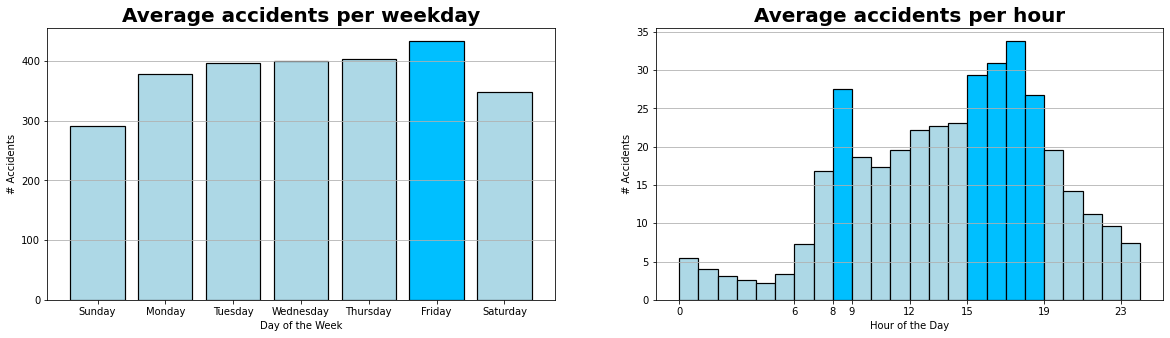

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
df['Timestamp'] = pd.to_datetime(df['Date'] + " " +df['Time'], format='%d/%m/%Y %H:%M')

# Plot day of week
ax = axs[0]
plt.sca(ax)
plt.gca().yaxis.grid(True)

date_counts = pd.DataFrame(df.set_index('Timestamp').resample('1d')['Accident_Index'].size().reset_index())
date_counts.columns = ['Date', 'Count']
dayname = date_counts['Date'].dt.day_name()
weekday_averages = pd.DataFrame(date_counts.groupby(dayname)['Count'].mean().reset_index())
weekday_averages.columns = ['Weekday', 'Average_Accidents']
weekday_averages.set_index('Weekday', inplace=True)
days = [code2label('Day_of_Week', d) for d in range(1, 7+1)]
colors=['lightblue' for d in range(1, 7+1)]
colors[-2] = 'deepskyblue'

weekday_averages = weekday_averages.reindex(days)
ax.bar(days, weekday_averages.values.reshape(-1), color=colors, edgecolor='black', linewidth=1.2)
ax.set_title("Average accidents per weekday", fontsize=20, fontweight='bold')
ax.set(xlabel='Day of the Week', ylabel='# Accidents')

# Plot time of day
ax = axs[1]
plt.sca(ax)
plt.gca().yaxis.grid(True)

per_hour_counts = pd.DataFrame(df.set_index('Timestamp').resample('1H')['Accident_Index'].size().reset_index())
per_hour_counts.columns = ['Hour', 'Count']
hours = per_hour_counts['Hour'].dt.hour

hours_name = [i for i in range(0, 24)]
hour_average = pd.DataFrame(per_hour_counts.groupby(hours)['Count'].mean().reset_index())
hour_average.columns = ['Hour', 'Average_Accidents']
hour_average.set_index('Hour', inplace=True)
hour_average = hour_average.reindex(hours_name)
colors=['lightblue' for h in hours]

top5value = sorted(list(hour_average.values.reshape(-1)))[-5]
for i, v in enumerate(list(hour_average.values.reshape(-1))):
    if v >= top5value:
        colors[i] = 'deepskyblue'

ax.bar(hours_name, hour_average.values.reshape(-1), color=colors, edgecolor='black', linewidth=1.2, width=1.0, align="edge")
ax.set_title('Average accidents per hour', fontsize=20, fontweight='bold')
ax.set(xlabel='Hour of the Day', ylabel='# Accidents')
ax.set_xticks([0,6,8,9,12,15,19,23])
plt.show()

Next, we examine how the accident distributed through the weekday and the hour of the day. From the left figure, we can see that accidents happen most frequently on Friday, and least frequently on Saturday and Sunday. From the right figure, we can observe that the accident happened most frequently in 8-9 AM and 3-7 PM.

In [13]:
def display_accidient_distribution_severity(df, col, title=None):
    fig, axs = plt.subplots(1, 2, figsize=(20,5), gridspec_kw={'width_ratios': [1, 3]})
    plt.subplots_adjust(wspace = 0.3)
    title = col if title is None else title
    
    # Pie
    ax = axs[0]             
    cnts = df[col].value_counts()
    ax.set_title('Accident Distribution: {}'.format(title), fontsize=20, fontweight='bold')
    labels = list(cnts.index)
    sizes = list(cnts.values)
    explode = tuple([0 for i in range(len(cnts.index))])
    ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
                                                               
    # severity_ratio
    ax = axs[1]
    total = len(df)
    Severitys = [1, 2, 3]
    Conds = sorted(list(set(df[col])))
    data = dict()
    for c in Conds:
        data[str(c)] = [0 for _ in range(len(Severitys))]
        cnts = df[df[col]==c]['Accident_Severity'].value_counts()
        for (idx, val) in zip (cnts.index, cnts.values):
            i = Severitys.index(idx)
            data[str(c)][i] = val
    
    ax.set_title('Accident Severity: {}'.format(title), fontsize=20, fontweight='bold')
    df = pd.DataFrame(data, index=Severitys)
    df = df.apply(lambda x: x/x.sum(), axis=0)
    df = df.T
    df.columns = [code2label('Casualty Severity', s) for s in df.columns]
    newcolors = cm.get_cmap('afmhot', 256)(np.linspace(0.25, 0.65, 128))
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    newcmp = ListedColormap(newcolors)
    df.plot(ax=ax, kind='barh', stacked=True, cmap=newcmp) 
                                                               
    plt.show()

Number of missing value: 117 (0.01%)


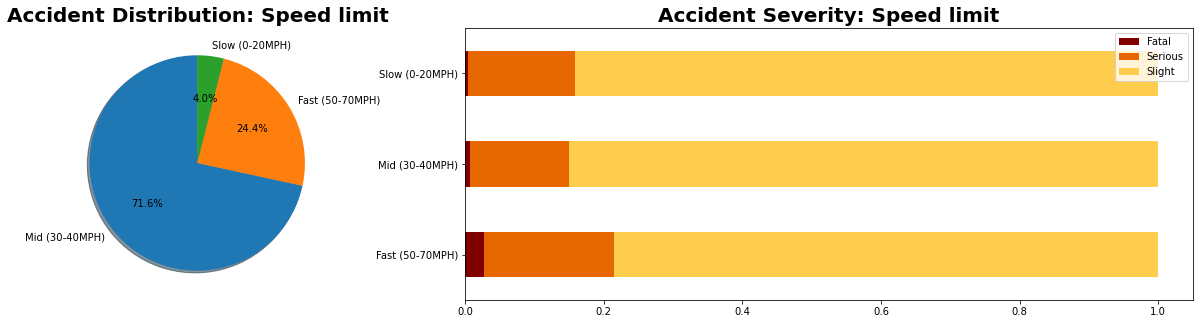

In [14]:
def catrgorize_Speed_limit(speed):
    if speed <= 20:
        return "Slow (0-20MPH)"
    if speed <= 40:
        return "Mid (30-40MPH)"
    else:
        return "Fast (50-70MPH)" 

df_speed = remove_missing_value(df_Accidents, ['Accident_Severity', 'Speed_limit'])
df_speed['speed'] = df_speed['Speed_limit'].apply(catrgorize_Speed_limit)
display_accidient_distribution_severity(df_speed, 'speed', "Speed limit")

Here we analyze the relationship between the speed limit of the road and the accident. From the pie chart, we can see most accidents happened on the road with a speed limit of 30-40 MPH (71.6%). From the bar chart, we can further find that the accident that happened on the road with a higher speed limit would more possibly result in fatal casualty.

Number of missing value: 15 (0.00%)


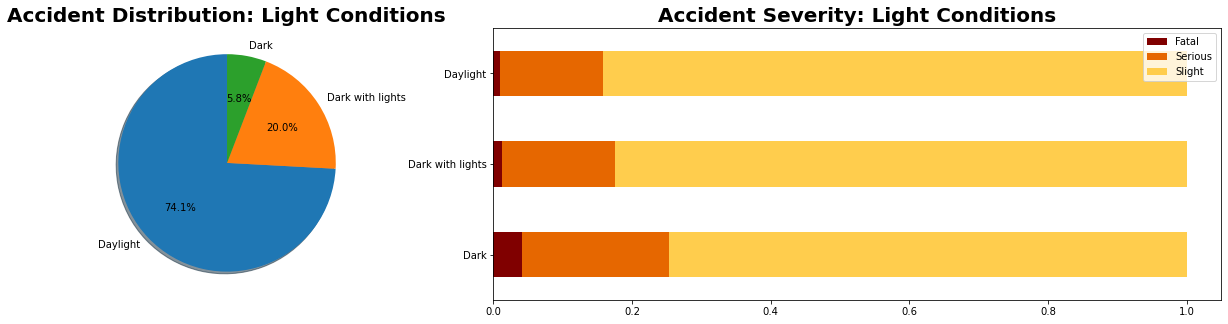

In [15]:
def catrgorize_Light_condition(light):
    if light == 1:
        return "Daylight"
    if light == 4:
        return "Dark with lights"
    if light == 5 or light == 6:
        return "Dark"

df_light = remove_missing_value(df_Accidents, ['Accident_Severity', 'Light_Conditions'])
df_light = df_light[df_light['Light_Conditions'] != 7] # Unknown
df_light['light'] = df_light['Light_Conditions'].apply(catrgorize_Light_condition)
display_accidient_distribution_severity(df_light, 'light', "Light Conditions")

We also examine the relation between light condition and accident. From the pie chart, we can see that most accidents happen in the day light environment (74.1%). However, when the accident happened in the dark without a lighting environment, it is more possibly result in fatal casualty.

## 3.2 Casualties

In [16]:
df_Casualties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1838789 entries, 0 to 153157
Data columns (total 16 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   Accident_Index                      object 
 1   Vehicle_Reference                   int64  
 2   Casualty_Reference                  int64  
 3   Casualty_Class                      int64  
 4   Sex_of_Casualty                     int64  
 5   Age_Band_of_Casualty                int64  
 6   Accident_Severity                   int64  
 7   Pedestrian_Location                 int64  
 8   Pedestrian_Movement                 int64  
 9   Car_Passenger                       int64  
 10  Bus_or_Coach_Passenger              int64  
 11  Pedestrian_Road_Maintenance_Worker  int64  
 12  Casualty_Type                       int64  
 13  Casualty_Home_Area_Type             int64  
 14  Age_of_Casualty                     float64
 15  Casualty_IMD_Decile                 float64
dtypes

Number of missing value: 31274 (1.70%)


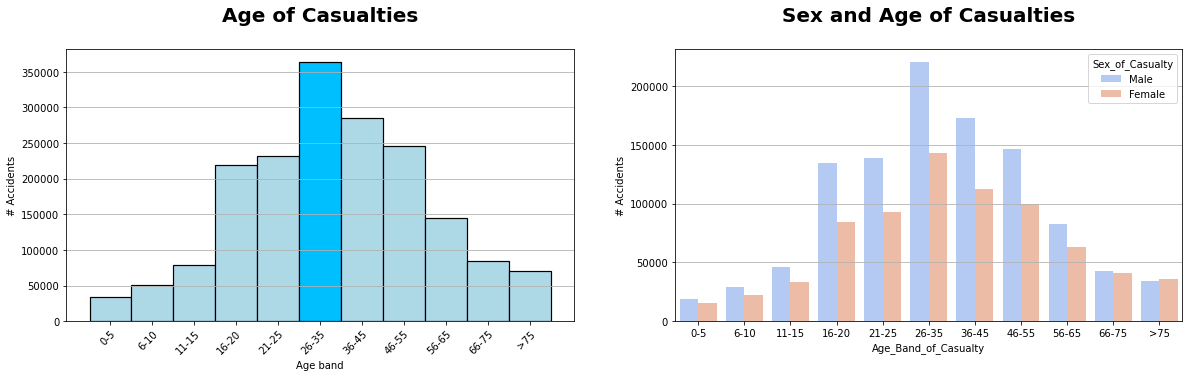

In [17]:
df = remove_missing_value(df_Casualties, ['Accident_Severity', 'Age_Band_of_Casualty', 'Sex_of_Casualty'])

fig, axs = plt.subplots(1, 2, figsize=(20,5))

# Age_Band_of_Casualty
ax = axs[0]
plt.sca(ax)
plt.gca().yaxis.grid(True)
df_age = df[df['Age_Band_of_Casualty'] != -1]
names = TABLE['Age Band']['label']

N, bins, patches = ax.hist(df_age['Age_Band_of_Casualty'].values, bins=[i for i in range(1,12+1)], color='lightblue', edgecolor='black', linewidth=1.2)
ax.set_xticks([i+0.5 for i in range(1, 11+1)])
ax.set_xticklabels(names, rotation=45, rotation_mode="anchor", ha="right")
for n, thispatch in zip(N, patches):
    if n == N.max(): 
        thispatch.set_facecolor('deepskyblue')
ax.set_title('Age of Casualties\n', fontsize=20, fontweight='bold')
ax.set(xlabel='Age band', ylabel='# Accidents')

## Sex and age
ax = axs[1]
plt.sca(ax)
plt.gca().yaxis.grid(True)
df_sex_age = df.groupby(['Age_Band_of_Casualty', 'Sex_of_Casualty']).size().reset_index()
df_sex_age = df_sex_age[df_sex_age['Age_Band_of_Casualty'] != -1] 
df_sex_age = df_sex_age[df_sex_age['Sex_of_Casualty'] != -1] 
df_sex_age.columns = ['Age_Band_of_Casualty', 'Sex_of_Casualty', "# Accidents"]
df_sex_age['Age_Band_of_Casualty'] = df_sex_age['Age_Band_of_Casualty'].map(
    dict(zip(TABLE['Age Band']['code'], TABLE['Age Band']['label'])))
df_sex_age['Sex_of_Casualty'] = df_sex_age['Sex_of_Casualty'].map(
    dict(zip(TABLE['Sex']['code'], TABLE['Sex']['label'])))
ax = sns.barplot(data=df_sex_age, x='Age_Band_of_Casualty', y='# Accidents', hue='Sex_of_Casualty', palette='coolwarm')
ax.set_title('Sex and Age of Casualties\n', fontsize=20, fontweight='bold')
plt.show()

For casualties of accidents, we first look at how the casualties were distributed through different age band and sex. From the left figure, we can observe that accidents happen most with the young and middle people (especially 26-35), and least happened with the child or older people. From the right figure, we can further find that the male casualties are more than female casualties in every age band.

Number of missing value: 15 (0.00%)


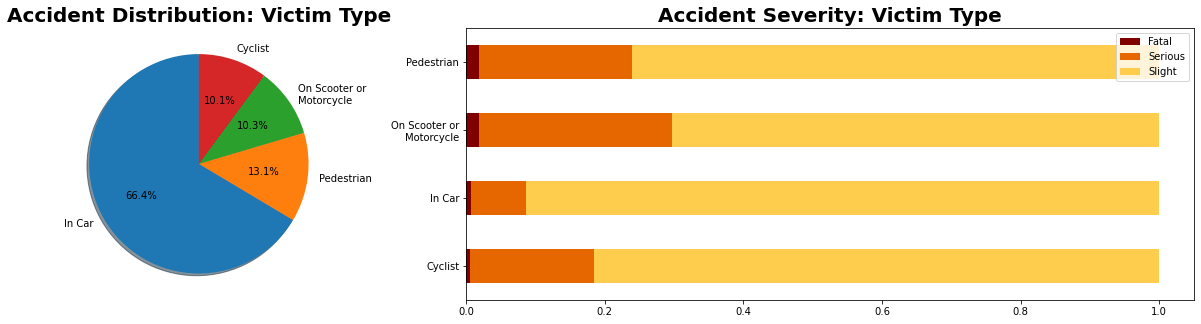

In [18]:
# Casualty Type
def catrgorize_victim(victim):
    if victim in [0]:
        return "Pedestrian"
    elif victim in [1]:
        return "Cyclist"
    elif victim in [2, 3,4,5,22,23,97]:
        return "On Scooter or\nMotorcycle"
    elif victim in [8,9,10,11,17,18,19,20,21,90,98]:
        return "In Car"
    else:
        return "Other"

df_victim = remove_missing_value(df_Casualties, ['Accident_Severity', 'Casualty_Type'])
df_victim = df_victim[df_victim['Casualty_Type']!=16]# Remove horse
df_victim['victim'] = df_victim['Casualty_Type'].apply(catrgorize_victim)
display_accidient_distribution_severity(df_victim, 'victim', "Victim Type")

Next, we examine the type of transportation method for the victim, and we can find that most casualties are in the vehicle (66.4%), while other types nearly percentage (around 10%). However, when an accident happened, the casualties in the car were least likely to result in serious damage or death than the casualties not in the car.  

## 3.3 Vehicles

In [19]:
df_Vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2428778 entries, 0 to 175664
Data columns (total 26 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   Accident_Index                    object 
 1   Accident_Severity                 int64  
 2   Acc_Index                         object 
 3   Vehicle_Reference                 int64  
 4   Vehicle_Type                      int64  
 5   Towing_and_Articulation           int64  
 6   Vehicle_Manoeuvre                 int64  
 7   Vehicle_Location-Restricted_Lane  int64  
 8   Junction_Location                 int64  
 9   Skidding_and_Overturning          int64  
 10  Hit_Object_in_Carriageway         int64  
 11  Vehicle_Leaving_Carriageway       int64  
 12  Hit_Object_off_Carriageway        int64  
 13  1st_Point_of_Impact               int64  
 14  Was_Vehicle_Left_Hand_Drive       float64
 15  Journey_Purpose_of_Driver         int64  
 16  Sex_of_Driver                     int

Number of missing value: 280293 (11.54%)
# Missing Value for Accident_Severity 0
# Missing Value for Age_Band_of_Driver 280285
# Missing Value for Sex_of_Driver 62


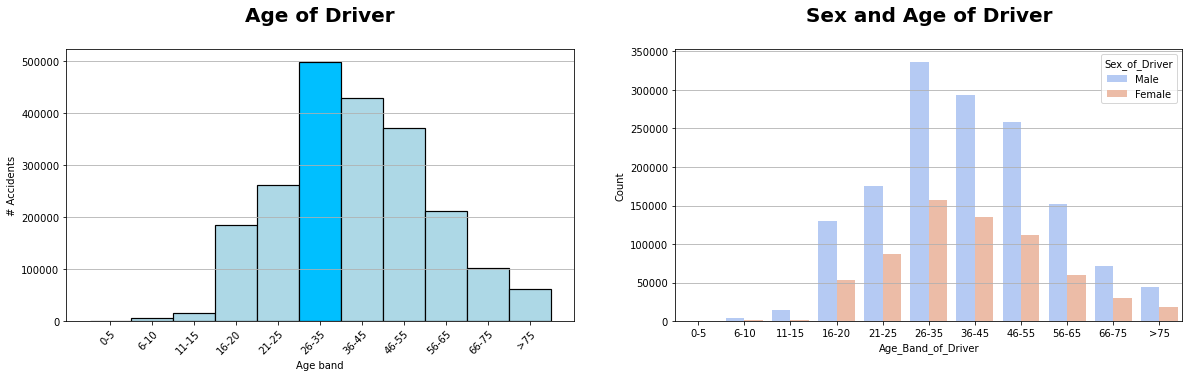

In [20]:
df = remove_missing_value(df_Vehicles, ['Accident_Severity', 'Age_Band_of_Driver', 'Sex_of_Driver'])
print("# Missing Value for Accident_Severity", (df_Vehicles['Accident_Severity']==-1).sum())
print("# Missing Value for Age_Band_of_Driver",(df_Vehicles['Age_Band_of_Driver']==-1).sum())
print("# Missing Value for Sex_of_Driver",(df_Vehicles['Sex_of_Driver']==-1).sum())
fig, axs = plt.subplots(1, 2, figsize=(20,5))

# Age_Band_of_Driver
ax = axs[0]
plt.sca(ax)
plt.gca().yaxis.grid(True)
df_age = df[df['Age_Band_of_Driver'] != -1]
names = TABLE['Age Band']['label']

N, bins, patches = ax.hist(df_age['Age_Band_of_Driver'].values, bins=[i for i in range(1,12+1)], color='lightblue', edgecolor='black', linewidth=1.2)
ax.set_xticks([i+0.5 for i in range(1, 11+1)])
ax.set_xticklabels(names, rotation=45, rotation_mode="anchor", ha="right")
for n, thispatch in zip(N, patches):
    if n == N.max(): 
        thispatch.set_facecolor('deepskyblue')
ax.set_title('Age of Driver\n', fontsize=20, fontweight='bold')
ax.set(xlabel='Age band', ylabel='# Accidents')
plt.gca().yaxis.grid(True)

## Sex and age
ax = axs[1]
plt.sca(ax)
plt.gca().yaxis.grid(True)

df_sex_age = df.groupby(['Age_Band_of_Driver', 'Sex_of_Driver']).size().reset_index()
df_sex_age = df_sex_age[df_sex_age['Age_Band_of_Driver'] != -1] 
df_sex_age = df_sex_age[df_sex_age['Sex_of_Driver'] != -1] 
df_sex_age.columns = ['Age_Band_of_Driver', 'Sex_of_Driver', "Count"]
df_sex_age['Age_Band_of_Driver'] = df_sex_age['Age_Band_of_Driver'].map(
    dict(zip(TABLE['Age Band']['code'], TABLE['Age Band']['label'])))
df_sex_age['Sex_of_Driver'] = df_sex_age['Sex_of_Driver'].map(
    dict(zip(TABLE['Sex']['code'], TABLE['Sex']['label'])))
ax = sns.barplot(data=df_sex_age, x='Age_Band_of_Driver', y='Count', hue='Sex_of_Driver', palette='coolwarm')
ax.yaxis.grid()
ax.set_title('Sex and Age of Driver\n', fontsize=20, fontweight='bold')
plt.gca().yaxis.grid(True)
plt.show()

For drivers that cause an accident, we first look at how the casualties were distributed through different age band and sex. From the left figure, we can observe that accidents happen most with the young and middle people (especially 26-35), and least happened with the child or older people. From the right figure, we can further find that the male casualties are more than female casualties in every age band. The result here is quite similar to the result of Age and sex of casualty, except for that there are fewer drivers whose age is under 15.  

Number of missing value: 1223 (0.05%)


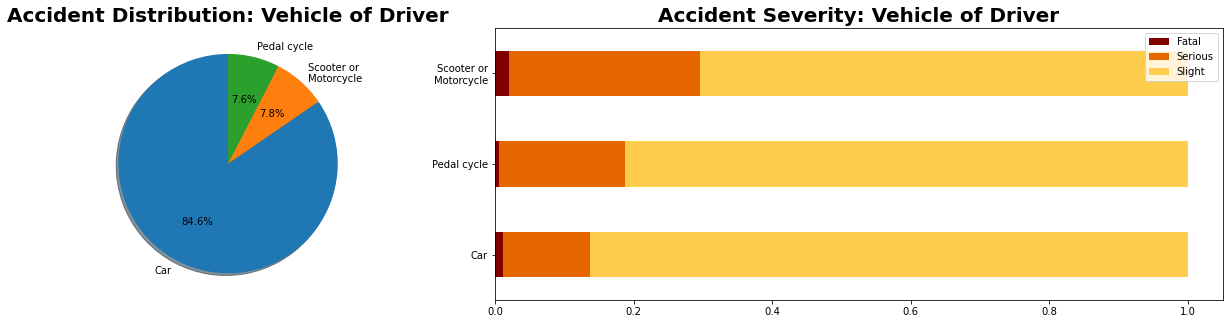

In [21]:
def catrgorize_driver_vehicle(driver_vehicle):
    if driver_vehicle in [1]:
        return "Pedal cycle"
    elif driver_vehicle in [2, 3,4,5,22,23,97]:
        return "Scooter or\nMotorcycle"
    elif driver_vehicle in [8,9,10,11,17,18,19,20,21,90,98]:
        return "Car"
    else:
        return "Other"

df_driver = remove_missing_value(df_Vehicles, ['Accident_Severity', 'Vehicle_Type'])
df_driver = df_driver[df_driver['Vehicle_Type']!=16]# Remove horse
df_driver['driver'] = df_driver['Vehicle_Type'].apply(catrgorize_driver_vehicle)
display_accidient_distribution_severity(df_driver, 'driver', "Vehicle of Driver")    

Next, we examine the factors related to accident. We first view the type of vehicle of driver. From the pie chart, we can know that in most accident, the vehicle of driver is car (about 85%). However, the accidents that caused by a motorcycle driver would more likely lead to serious and fatal casualties.

Number of missing value: 671415 (27.64%)


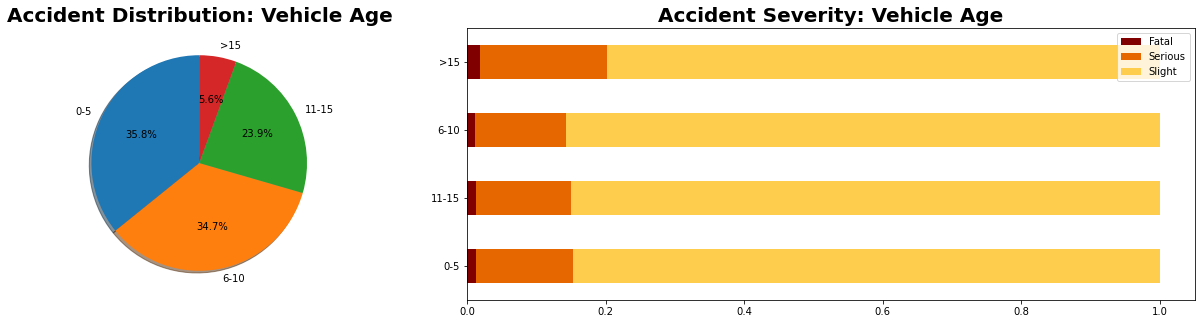

In [22]:
def catrgorize_vehicle_age(age):
    if age <= 5:
        return "0-5"
    elif age <= 10:
        return "6-10"
    elif age <= 15:
        return "11-15"
    else:
        return ">15"

df_age = remove_missing_value(df_Vehicles, ['Accident_Severity', 'Age_of_Vehicle'])
df_age['age'] = df_age['Age_of_Vehicle'].apply(catrgorize_vehicle_age)
display_accidient_distribution_severity(df_age, 'age', "Vehicle Age")     

We also examine the relationship between vehicle age and the accident. For the pie chart and the bar chart, we can observe that although accident with the vehicle age above 15 is not common (only 5.6%), but it is more likely to result in serious and fatal casualties. 

# 4. Conclusion

This report analyzes the road safety data in the UK, and provide main characteristics with visual aids from three different aspects of an accident, including the circumstances of accidents, the victims of accidents, and the vehicles and drivers that cause the accidents.

In addition, many interesting facts were discovered during the analysis, such as when accident most happen with casualties in a car, the accident happened in a car are less likely to result in serious or fatal casualties than those casualties not in a car. 

I believe this report is helpful to understand the characteristics and structure of the dataset, and it can be used to further research, such as analysis of the hotspot of accidents, or building a predictive model to predict whether a casualty is fatal. 


# 5. Preliminary thoughts of how to build a predictive model

## 5.1 Data cleaning
remove invalid or missing data or replace those data with mean, median, or the majority of valid data.

## 5.2 Spliting Dataset
split the dataset into training, validation, and test set with a ratio of 80%, 10%, and 10%. Meanwhile, I would keep the ratio of positive and negative data is equal across the different set.


## 5.3 Undersampling or oversampling of training set
I would consider using the ENN (Edited Nearest Neighbor) approach for undersampling.
For oversampling, I would first try the classical approach such as SMOTE (Synthetic Minority Oversampling Technique), and try some new approach based on GAN (Generative Adversarial Network).

## 5.4 Build classifier 
I would start from random forest and AdaBoost classifier
then turning and selecting the best model to have the highest f1-score on the validation set.
Finally, I would test the performance of that model on the test set.